In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import re
import time
import nltk
from nltk.corpus import stopwords
import scipy.sparse as sp

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import   roc_auc_score,multilabel_confusion_matrix
from sklearn.preprocessing import StandardScaler
#from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier,RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display

submission_file = pd.read_csv( '../.data/sample_submission.csv')

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from features.build_features import text_stats_features
from visualize.plot_learning_curve import plot_curve

ModuleNotFoundError: No module named 'nltk'

#### For now we want to have a glance at a baseline model, so we are not using nothing besides the comment_text with TF-IDF and a Logistic Regression with no tunning

- Not using the features created in 'EDA.ipynb'

In [2]:
def import_train_data():
    Xtrain = pd.read_csv('../.data/train_new_features.csv',index_col='id')
    Xtr = Xtrain[['comment_text']]
    ytr = Xtrain[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate']]   
    return Xtr,ytr

def feature_extraction(Xtr,n_grams=(1,1),max_features=10000):
    word_vectorizer = TfidfVectorizer(
        sublinear_tf=True,
        use_idf=True,
        strip_accents='unicode',
        stop_words='english',
        min_df=20,
        ngram_range=n_grams,
        max_features=max_features)
    
    start = time.time()
    print('Extracting fetures...')
    train_features = word_vectorizer.fit_transform(Xtr['comment_text'])
    print(f'Time elapsed: {time.time() - start} seconds. ')
    param = word_vectorizer.get_params()
    return train_features,param

def train_model(Xtr,ytr,df_results,param_extractor,c_weight='balanced'):
    
    clf = LogisticRegression(class_weight=c_weight) #'balanced'
    param_classifier = clf.get_params()
    score_df = pd.DataFrame(columns=ytr.columns)
    scores = []
    
    for col in ytr.columns:
        cv_score = np.round(np.mean(cross_val_score(clf,
                                           Xtr,
                                           ytr[col],
                                           cv=3,
                                           scoring='roc_auc')),4)
        scores.append(cv_score)
        print(f'CV score for label {col} is {cv_score}.')
        
    scores.append(param_extractor)
    scores.append(param_classifier)
    df_results = df_results.append(dict(zip(df_results.columns,scores)), ignore_index = True)
    
    return df_results

In [3]:
x_train, y_train = import_train_data()
list_cols = y_train.columns.to_list()
list_cols.append('parameters_extraction')
list_cols.append('parameters_classifier')
score_df = pd.DataFrame(columns=list_cols)
#x_train_transformed,parameters_feat_ext = feature_extraction(x_train)

## Test different class weights

In [6]:
weights = [{0:1,1:1},{0:1,1:10},{0:1,1:100}]
for w in weights:
    score_df = train_model(x_train_transformed,y_train,
                           score_df,parameters_feat_ext,c_weight=w)
    

CV score for label toxic is 0.9675.
CV score for label severe_toxic is 0.9851.
CV score for label obscene is 0.9832.
CV score for label threat is 0.9825.
CV score for label insult is 0.9744.
CV score for label identity_hate is 0.9732.
CV score for label toxic is 0.9657.
CV score for label severe_toxic is 0.9828.
CV score for label obscene is 0.9813.
CV score for label threat is 0.9819.
CV score for label insult is 0.9729.
CV score for label identity_hate is 0.9702.
CV score for label toxic is 0.9624.
CV score for label severe_toxic is 0.9806.
CV score for label obscene is 0.9793.
CV score for label threat is 0.9801.
CV score for label insult is 0.9706.
CV score for label identity_hate is 0.9674.


In [7]:
display(score_df)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,parameters_extraction,parameters_classifier
0,0.9675,0.9851,0.9832,0.9825,0.9744,0.9732,"{'analyzer': 'word', 'binary': False, 'decode_...","{'C': 1.0, 'class_weight': None, 'dual': False..."
1,0.9675,0.9851,0.9832,0.9825,0.9744,0.9732,"{'analyzer': 'word', 'binary': False, 'decode_...","{'C': 1.0, 'class_weight': {0: 1, 1: 1}, 'dual..."
2,0.9657,0.9828,0.9813,0.9819,0.9729,0.9702,"{'analyzer': 'word', 'binary': False, 'decode_...","{'C': 1.0, 'class_weight': {0: 1, 1: 10}, 'dua..."
3,0.9624,0.9806,0.9793,0.9801,0.9706,0.9674,"{'analyzer': 'word', 'binary': False, 'decode_...","{'C': 1.0, 'class_weight': {0: 1, 1: 100}, 'du..."


Conclusion: Attributing different class_weights does not seem to be improving our scores so far.

## Search n_gram_range

In [8]:
list_cols = y_train.columns.to_list()
list_cols.append('parameters_extraction')
list_cols.append('parameters_classifier')
score_df = pd.DataFrame(columns=list_cols)

for n_gram_range in [(1,2),(1,3),(1,4),(2,3)]:
    x_train_transformed,parameters_feat_ext = feature_extraction(x_train,n_gram_range)
    score_df = train_model(x_train_transformed,y_train,
                           score_df,parameters_feat_ext)

Extracting fetures...
Time elapsed: 18.977115392684937 seconds. 
CV score for label toxic is 0.9652.
CV score for label severe_toxic is 0.9815.
CV score for label obscene is 0.9807.
CV score for label threat is 0.9808.
CV score for label insult is 0.9726.
CV score for label identity_hate is 0.9693.
Extracting fetures...
Time elapsed: 36.379775047302246 seconds. 
CV score for label toxic is 0.9645.
CV score for label severe_toxic is 0.9813.
CV score for label obscene is 0.9804.
CV score for label threat is 0.9793.
CV score for label insult is 0.9722.
CV score for label identity_hate is 0.9679.
Extracting fetures...
Time elapsed: 54.11032557487488 seconds. 
CV score for label toxic is 0.964.
CV score for label severe_toxic is 0.9813.
CV score for label obscene is 0.9803.
CV score for label threat is 0.9792.
CV score for label insult is 0.972.
CV score for label identity_hate is 0.9673.
Extracting fetures...
Time elapsed: 32.74915313720703 seconds. 
CV score for label toxic is 0.7668.
CV 

In [9]:
display(score_df)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,parameters_extraction,parameters_classifier
0,0.9652,0.9815,0.9807,0.9808,0.9726,0.9693,"{'analyzer': 'word', 'binary': False, 'decode_...","{'C': 1.0, 'class_weight': 'balanced', 'dual':..."
1,0.9645,0.9813,0.9804,0.9793,0.9722,0.9679,"{'analyzer': 'word', 'binary': False, 'decode_...","{'C': 1.0, 'class_weight': 'balanced', 'dual':..."
2,0.9640,0.9813,0.9803,0.9792,0.9720,0.9673,"{'analyzer': 'word', 'binary': False, 'decode_...","{'C': 1.0, 'class_weight': 'balanced', 'dual':..."
3,0.7668,0.8384,0.7770,0.7882,0.7822,0.7627,"{'analyzer': 'word', 'binary': False, 'decode_...","{'C': 1.0, 'class_weight': 'balanced', 'dual':..."


Conclusion: We found no evidence that increasing n_gram range could improve our scores.
We could add more to max_features instead.

## Search max_features

In [9]:
list_cols = y_train.columns.to_list()
list_cols.append('parameters_extraction')
list_cols.append('parameters_classifier')
score_df = pd.DataFrame(columns=list_cols)

for max_feats in [1.5e4,3e4,5e4]:
    print(max_feats)
    x_train_transformed,parameters_feat_ext = feature_extraction(x_train,
                                                                 max_features=int(max_feats))
    score_df = train_model(x_train_transformed,y_train,
                           score_df,parameters_feat_ext)

15000.0
Extracting fetures...
Time elapsed: 6.39243483543396 seconds. 
CV score for label toxic is 0.9689.
CV score for label severe_toxic is 0.9834.
CV score for label obscene is 0.9833.
CV score for label threat is 0.9814.
CV score for label insult is 0.9755.
CV score for label identity_hate is 0.9706.
30000.0
Extracting fetures...
Time elapsed: 7.328493118286133 seconds. 
CV score for label toxic is 0.9689.
CV score for label severe_toxic is 0.9834.
CV score for label obscene is 0.9833.
CV score for label threat is 0.9814.
CV score for label insult is 0.9755.
CV score for label identity_hate is 0.9706.
50000.0
Extracting fetures...
Time elapsed: 7.240565061569214 seconds. 
CV score for label toxic is 0.9689.
CV score for label severe_toxic is 0.9834.
CV score for label obscene is 0.9833.
CV score for label threat is 0.9814.
CV score for label insult is 0.9755.
CV score for label identity_hate is 0.9706.


In [15]:
display(score_df)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,parameters_extraction,parameters_classifier
0,0.9689,0.9834,0.9833,0.9814,0.9755,0.9706,"{'analyzer': 'word', 'binary': False, 'decode_...","{'C': 1.0, 'class_weight': 'balanced', 'dual':..."
1,0.9689,0.9834,0.9833,0.9814,0.9755,0.9706,"{'analyzer': 'word', 'binary': False, 'decode_...","{'C': 1.0, 'class_weight': 'balanced', 'dual':..."
2,0.9689,0.9834,0.9833,0.9814,0.9755,0.9706,"{'analyzer': 'word', 'binary': False, 'decode_...","{'C': 1.0, 'class_weight': 'balanced', 'dual':..."


Conclusion: Now we seem to reach something, but the model does not seem to show any improvement with more than 15k terms.
We could try now work with both max_features and n_gram_range.


## Search max_features and n_gram_range

In [13]:
list_cols = y_train.columns.to_list()
list_cols.append('parameters_extraction')
list_cols.append('parameters_classifier')
score_df = pd.DataFrame(columns=list_cols)
# 3e4 and (1,2)
for max_feats in [1.5e4,3e4]:
    for n_gram_range in [(1,2),(1,3)]:
    
        x_train_transformed,parameters_feat_ext = feature_extraction(x_train,
                                                                     n_gram_range,
                                                                     int(max_feats))
        score_df = train_model(x_train_transformed,y_train,
                               score_df,parameters_feat_ext)

Extracting fetures...
Time elapsed: 18.222862005233765 seconds. 
CV score for label toxic is 0.9669.
CV score for label severe_toxic is 0.9828.
CV score for label obscene is 0.9818.
CV score for label threat is 0.9807.
CV score for label insult is 0.9738.
CV score for label identity_hate is 0.9707.
Extracting fetures...
Time elapsed: 35.48916292190552 seconds. 
CV score for label toxic is 0.9664.
CV score for label severe_toxic is 0.9823.
CV score for label obscene is 0.9813.
CV score for label threat is 0.9808.
CV score for label insult is 0.9732.
CV score for label identity_hate is 0.9707.
Extracting fetures...
Time elapsed: 19.025423765182495 seconds. 
CV score for label toxic is 0.9691.
CV score for label severe_toxic is 0.9839.
CV score for label obscene is 0.9835.
CV score for label threat is 0.9822.
CV score for label insult is 0.9757.
CV score for label identity_hate is 0.9713.
Extracting fetures...
Time elapsed: 36.50981831550598 seconds. 
CV score for label toxic is 0.9688.
C

In [58]:
display(score_df)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,parameters_extraction,parameters_classifier
0,0.9669,0.9828,0.9818,0.9807,0.9738,0.9707,"{'analyzer': 'word', 'binary': False, 'decode_...","{'C': 1.0, 'class_weight': 'balanced', 'dual':..."
1,0.9664,0.9823,0.9813,0.9808,0.9732,0.9707,"{'analyzer': 'word', 'binary': False, 'decode_...","{'C': 1.0, 'class_weight': 'balanced', 'dual':..."
2,0.9691,0.9839,0.9835,0.9822,0.9757,0.9713,"{'analyzer': 'word', 'binary': False, 'decode_...","{'C': 1.0, 'class_weight': 'balanced', 'dual':..."
3,0.9688,0.9838,0.9833,0.9818,0.9755,0.9710,"{'analyzer': 'word', 'binary': False, 'decode_...","{'C': 1.0, 'class_weight': 'balanced', 'dual':..."


Conclusion: Found a peak at max_feats = 3e4, n_gram_range = (1,2), row 2. We will keep these hyperparameters for now.

## Increase feature space with EDA notebook features.

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier


x_train, y_train = import_train_data()
list_cols = y_train.columns.to_list()
list_cols.append('parameters_extraction')
list_cols.append('parameters_classifier')
score_df = pd.DataFrame(columns=list_cols)

max_feats = 1.5e4
n_gram_range = (1,2)

x_train_vectorized,parameters_feat_ext = feature_extraction(x_train,
                                                             n_gram_range,
                                                             int(max_feats))

# text statistics from EDA notebook
text_statistics_features = text_stats_features(x_train)
norm_text_stats_feats = MinMaxScaler().fit_transform(text_statistics_features)
x_train_features = sp.hstack([x_train_vectorized,norm_text_stats_feats],format='csr')

Extracting fetures...
Time elapsed: 18.996933460235596 seconds. 


In [36]:
score_df = train_model(x_train_features,y_train,
                               score_df,parameters_feat_ext)

#display(score_df)

CV score for label toxic is 0.9697.
CV score for label severe_toxic is 0.9855.
CV score for label obscene is 0.9829.
CV score for label threat is 0.9792.
CV score for label insult is 0.975.
CV score for label identity_hate is 0.972.


Conclusion: Statistics from the text concerning word_counts, marks such as question and exclamation ones, as well as symbols and smiles improved our CV score for most labels. Only _insult_ that presented a decrement in its CV score.

## Learning Curves : Diagnostics

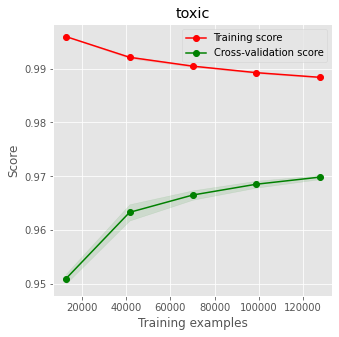

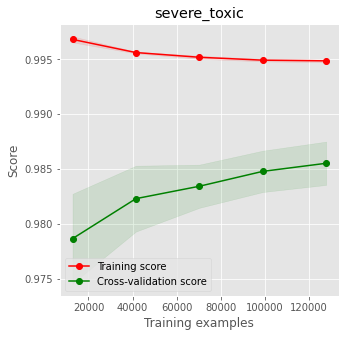

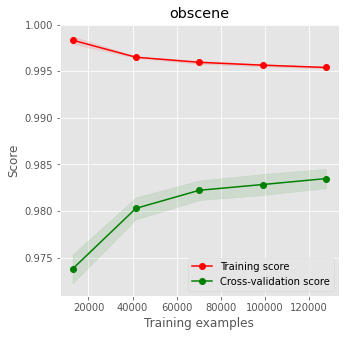

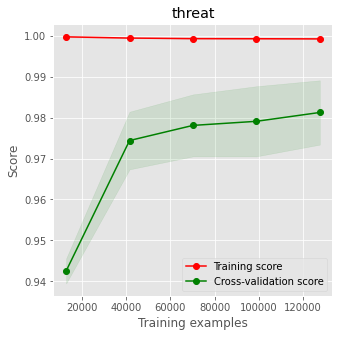

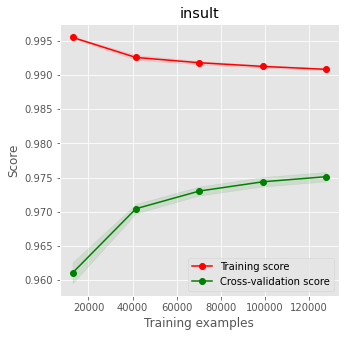

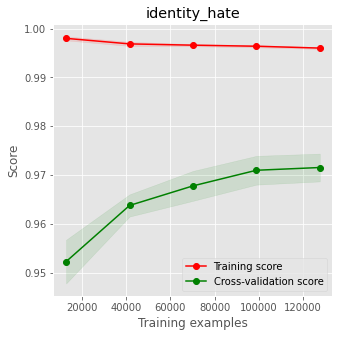

In [46]:
clf1 = LogisticRegression(class_weight='balanced') #'balanced'
plot_curve(clf1, x_train_features, y_train)

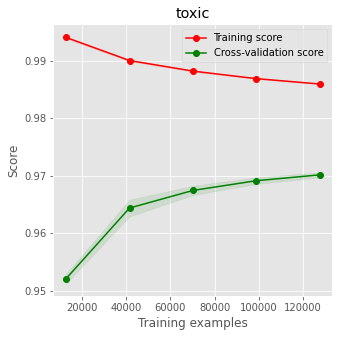

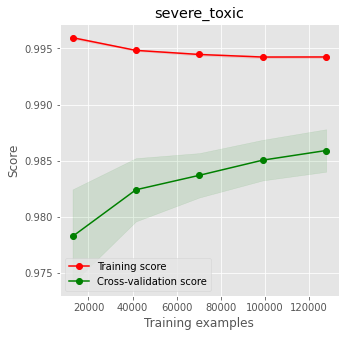

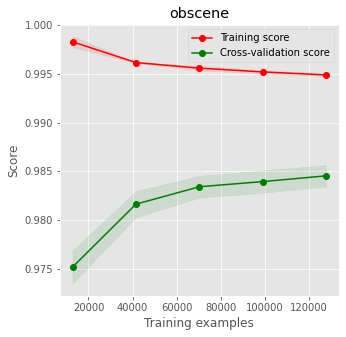

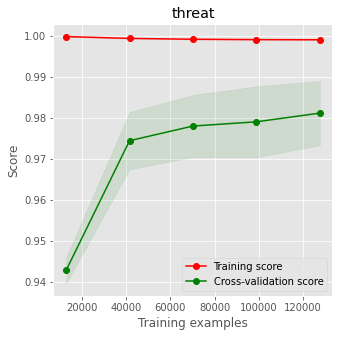

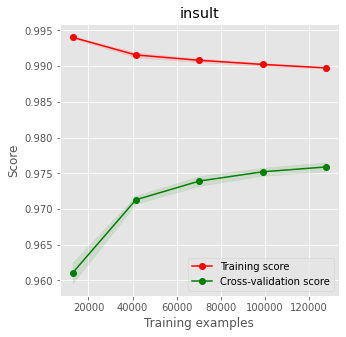

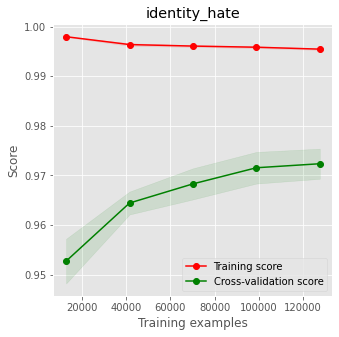

In [54]:
clf1 = LogisticRegression(class_weight='balanced') #'balanced'
clf2 = DecisionTreeClassifier(max_depth=4)
clf3 = MultinomialNB()
clf = VotingClassifier(
    estimators=[('lr', clf1),
                ('dt', clf2),
                ('mnb', clf3)], voting='soft')
    
plot_curve(clf, x_train_features, y_train)

In Threat more than any other the model seems to be overfitting, we could think of a stronger regularization for it.
In half of the labels we do have more than 2 points differences between mean training and validation score. We can focus on mitigating those learning issues.

## Decisions:

    Adding more training instances. [Not that feasible]
    Adding more features. [Possible]
    Feature selection. [Possible]
    Hyperparameter optimization. [Possible]


Notes : voting 'soft' requires classifiers that have their output probabilities well calibrated.

Conclusion: Although not presenting the worst score the 'threat' label presents a large standard deviation from the mean for the 5-fold CV score. As well the gap between mean train and test scores is the largest across labels.

We could interpret it as the concept of 'threat' to be learned is not as easily generalizable as the rest of the labels. Another aspect we could question is the labeling process, what if the definition of 'threat' is not homogeneous across the group of people labelling the sentences? Not to be forgotten, we are dealing with an imbalanced problem and that we can verify by ourselves based on the data distributions we have.

In [13]:
y_train.apply(pd.value_counts)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,144277,157976,151122,159093,151694,158166
1,15294,1595,8449,478,7877,1405


Conclusion: 'Threat' label in fact presents the least ammount of examples, almost a third of the second most imbalanced label. When we split it in train and test in fact would make sense that it fitted well the train set while presenting large variance in the test set. 

# Let's check the calibration curve first

In [1]:
# Calibrating:
from sklearn.calibration import calibration_curve

# not working yet
fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))